<a href="https://colab.research.google.com/github/s1c5000/Books/blob/main/handson/RNN%EA%B3%BC_CNN%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%B4_%EC%8B%9C%ED%80%80%EC%8A%A4_%EC%B2%98%EB%A6%AC_%EC%A0%95%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RNN의 동작방식과 구조를 설명한다  
입력의 shape부터 모델들의 weights, 출력의 shape를 모두 출력하며 보는것이 흐름을 이해하는데 도움이 된다.  

In [ ]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from pathlib import Path
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


Recurrent Neural Network  
RNN(순환신경망) 은 미래를 예측할 수 있는 신경망이다  
시계열 데이터 분석  




# 순환뉴런과 순환 층

순환 신경망은 피드포워드 신경망과 비슷하지만 뒤쪽으로 순환하는 연결도 있다.  

입력을 받아 출력을 만들고 자신에게도 출력을 내보낸다.  

각 타임스텝(프레임)마다 $X_(i)$를 입력으로 받고 이전 스텝의 출력인 $y_(i-1)$도 입력으로 받는다.   
첫번째 타임스텝은 이전입력이 없으므로 0으로 설정한다.  

이 작은 네트워크를 시간을 축으로하여 표현할 수 있다.

각 뉴런은 두벌의 가중치를 가진다. 하나는 입력 $X_{(i)}$를 위한 것이고 다른 하나는 이전 타임스텝의 출력 $y_{(i-1)}$을 위한 것이다.  
이 가중치 벡터를 $W_x$ 와 $W_y$라고 하겠다.  
하나의 순환 뉴런이 아니라 순환층 전체를 생각하면 가중치 벡터를 가중치 행렬 $W_x$ 와 $W_y$로 바꿀 수 있다.  
그러면 순환층 전체의 출력 벡터는 익숙한 형태인  

$ y_(i) = \phi( W_x ^TX_{(t)} +  W_y ^Ty_{(t-1)} + b) $  

로 계산된다.  
b는 편향, $\phi$는 활성화함수

## 메모리 셀
타임스텝 t에서 순환 뉴런의 출력은 이전 타임 스텝의 모든 입력에 대한 함수이므로 이를 일종의 메모리 형태라고 할 수 있다.  
타임 스텝에 걸쳐서 어떤 상태를 보존하는 신경망의 구성요소를 메모리 셀 이라고 한다.  
하나의 순환뉴런 또는 순환뉴런의 층은 짧은 패턴(보통 10스텝 길이)만 학습할 수 있는 매우 기본적인 셀이다.

일반적으로 타임 스텝 t에서의 셀 상태 $h_t$는 그 타임 스텝의 입력과 이전 타임 스텝의 상태에 대한 함수이다  
$h_t = f (h_{(t-1)}, x_{(t)})$이다  
출력 $y_t$도 이전 상태와 현재 입력에 대한 함수이다

## RNN훈련하기  
타임스텝으로 네트워크를 펼치고(펼친다고생각, 실제로 펼치거나 그런건 아님) 역전파를 사용하는 것이다.   
BPTT(backpropagation through time)이라고 한다  

첫번째 정방향 패스가 펼처진 네트워크를 통과한다  
그 후 비용함수 C(y(0), y(1),... y(t))를 사용하여 출력 시퀀스가 평가된다.  
비용함수의 그레이디언트는 네트워크를 따라 역방향으로 전파된다.



# 시계열 예측

In [ ]:
# 시계열 데이터 생성
# 
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) # 각각 10000개의 랜덤변수를 갖는다.
    #print(freq1.shape, freq1) # (10000,1) 
    #print(freq2.shape,freq2) # (10000,1)
  
    time = np.linspace(0, 1, n_steps) # 0~1 까지 n_steps개수가 되도록 나눔, (51,)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1, sin함수 모양으로 요동친다. 큰 트랜드
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2, 랜덤성 부여
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise, 랜덤성부여
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1) #(10000,50,1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
for i in series:
  print(i.shape)
  print(i)
  break

(51, 1)
[[ 0.4596948 ]
 [ 0.31486678]
 [ 0.12497123]
 [-0.1039134 ]
 [-0.33817387]
 [-0.53167135]
 [-0.65472883]
 [-0.6680997 ]
 [-0.6068115 ]
 [-0.50168324]
 [-0.27951923]
 [-0.15070675]
 [ 0.01001816]
 [ 0.11860766]
 [ 0.09566415]
 [ 0.1479297 ]
 [ 0.16850619]
 [ 0.19524719]
 [ 0.22094081]
 [ 0.38448656]
 [ 0.4021102 ]
 [ 0.5566975 ]
 [ 0.55000687]
 [ 0.47437248]
 [ 0.29733396]
 [ 0.13306592]
 [-0.1292547 ]
 [-0.36367297]
 [-0.49515054]
 [-0.65279794]
 [-0.6665792 ]
 [-0.5604573 ]
 [-0.50344354]
 [-0.28775147]
 [-0.12684062]
 [-0.0095053 ]
 [ 0.12024356]
 [ 0.18013756]
 [ 0.1559989 ]
 [ 0.1756968 ]
 [ 0.217454  ]
 [ 0.30272725]
 [ 0.38143268]
 [ 0.42323437]
 [ 0.46800318]
 [ 0.5632784 ]
 [ 0.42762673]
 [ 0.32104868]
 [ 0.13293117]
 [-0.15862931]
 [-0.35489398]]


[배치크기, 타임스텝수, 1]크기의 넘파이 배열을 반환

In [ ]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

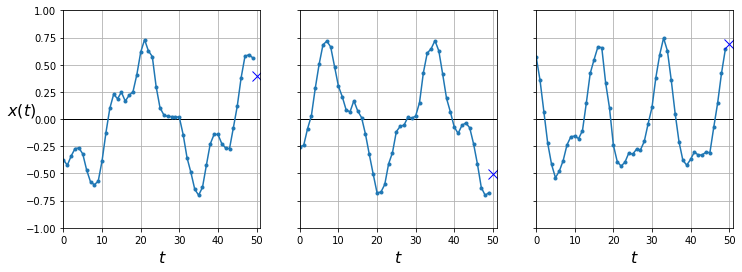

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))

plt.show()

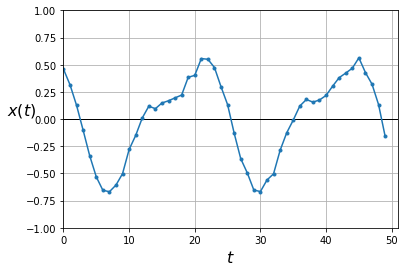

In [ ]:
plot_series(X_train[0])

In [ ]:
# 완전연결층으로 학습
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]), #  특정한 입력의 크기를 기대하기때문에 Flatten층을 추가
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.1865 - accuracy: 0.0000e+00 - val_loss: 0.0400 - val_accuracy: 0.0000e+00
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0331 - accuracy: 0.0000e+00 - val_loss: 0.0186 - val_accuracy: 0.0000e+00
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0169 - accuracy: 0.0000e+00 - val_loss: 0.0119 - val_accuracy: 0.0000e+00
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.0000e+00 - val_loss: 0.0093 - val_accuracy: 0.0000e+00
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 0.0000e+00 - val_loss: 0.0082 - val_accuracy: 0.0000e+00
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0079 - accuracy: 0.0000e+00 - val_loss: 0.0075 - val_accuracy: 0.0000e+00
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0072 - accuracy: 0.0000e

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


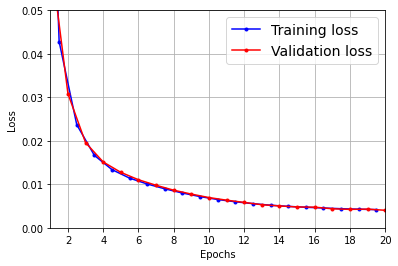

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

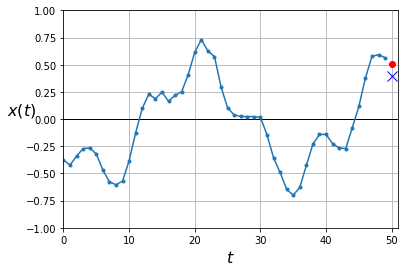

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0]) # 학습데이터, 정답, 예측값(빨강)
plt.show()

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 992us/step - loss: 0.0040 - accuracy: 0.0000e+00


[0.004031261894851923, 0.0]

## 간단한 RNN구현

순환 신경망은 어떤 길이의 타임 스텝스도 처리할 수 있기에 입력 시퀀스의 길이를 지정할 필요가 없다.  
기본적으로 SimpleRNN층은 하이퍼볼릭 탄젠트 활성화 함수를 사용한다.  




In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(2, input_shape=[None, 1]) # (1,50,1) 들어감
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer, metrics=['accuracy'])
# X_train.shape = (7000,50,1),    y_train.shape= (7000,1)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 10ms/step - loss: 0.2749 - accuracy: 0.0000e+00 - val_loss: 0.0523 - val_accuracy: 0.0000e+00
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0432 - accuracy: 0.0000e+00 - val_loss: 0.0281 - val_accuracy: 0.0000e+00
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0248 - accuracy: 0.0000e+00 - val_loss: 0.0203 - val_accuracy: 0.0000e+00
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0187 - accuracy: 0.0000e+00 - val_loss: 0.0162 - val_accuracy: 0.0000e+00
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0156 - accuracy: 0.0000e+00 - val_loss: 0.0138 - val_accuracy: 0.0000e+00
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0137 - accuracy: 0.0000e+00 - val_loss: 0.0124 - val_accuracy: 0.0000e+00
Epoch 7/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0121 - accuracy: 0.0000

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 2)                 8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.weights # 입력을 받는 가중치, 그 전 출력을 받는 가중치, 편향

[<tf.Variable 'simple_rnn/simple_rnn_cell/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[2.0529237, 1.4363492]], dtype=float32)>,
 <tf.Variable 'simple_rnn/simple_rnn_cell/recurrent_kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 0.65863305,  0.5615157 ],
        [-1.7721263 , -0.97494423]], dtype=float32)>,
 <tf.Variable 'simple_rnn/simple_rnn_cell/bias:0' shape=(2,) dtype=float32, numpy=array([0.00277479, 0.00406017], dtype=float32)>]

In [ ]:
print(X_train[1].shape) # (7000,50,1) 의 1번째 행이니 (50,1)
X_train[1]

(50, 1)


array([[ 0.24511378],
       [ 0.23174433],
       [-0.00599396],
       [-0.14533305],
       [-0.31580353],
       [-0.4388943 ],
       [-0.5878479 ],
       [-0.5458042 ],
       [-0.44855034],
       [-0.24629089],
       [ 0.05897167],
       [ 0.25053233],
       [ 0.55114156],
       [ 0.6936512 ],
       [ 0.7185335 ],
       [ 0.5795115 ],
       [ 0.33066   ],
       [ 0.05455513],
       [-0.18695112],
       [-0.44431937],
       [-0.6402944 ],
       [-0.62540805],
       [-0.5477814 ],
       [-0.35062551],
       [-0.12485091],
       [ 0.14836453],
       [ 0.36808363],
       [ 0.42955294],
       [ 0.56634104],
       [ 0.4632922 ],
       [ 0.36384302],
       [ 0.2479538 ],
       [ 0.0744473 ],
       [-0.04693193],
       [-0.2069649 ],
       [-0.2809638 ],
       [-0.3494651 ],
       [-0.310967  ],
       [-0.26699314],
       [-0.2730748 ],
       [-0.20220686],
       [-0.15053852],
       [ 0.0040438 ],
       [ 0.05242047],
       [ 0.246249  ],
       [ 0

In [ ]:
print(X_train[None,1].shape) # None을 붙인 자리만큼 고차원이 늘어난다.
print(X_train[None,None,1].shape)
print(X_train[None,1,None].shape)
print(X_train[1,None,None].shape)
X_train[None,1]

(1, 50, 1)
(1, 1, 50, 1)
(1, 1, 50, 1)
(1, 1, 50, 1)


array([[[ 0.24511378],
        [ 0.23174433],
        [-0.00599396],
        [-0.14533305],
        [-0.31580353],
        [-0.4388943 ],
        [-0.5878479 ],
        [-0.5458042 ],
        [-0.44855034],
        [-0.24629089],
        [ 0.05897167],
        [ 0.25053233],
        [ 0.55114156],
        [ 0.6936512 ],
        [ 0.7185335 ],
        [ 0.5795115 ],
        [ 0.33066   ],
        [ 0.05455513],
        [-0.18695112],
        [-0.44431937],
        [-0.6402944 ],
        [-0.62540805],
        [-0.5477814 ],
        [-0.35062551],
        [-0.12485091],
        [ 0.14836453],
        [ 0.36808363],
        [ 0.42955294],
        [ 0.56634104],
        [ 0.4632922 ],
        [ 0.36384302],
        [ 0.2479538 ],
        [ 0.0744473 ],
        [-0.04693193],
        [-0.2069649 ],
        [-0.2809638 ],
        [-0.3494651 ],
        [-0.310967  ],
        [-0.26699314],
        [-0.2730748 ],
        [-0.20220686],
        [-0.15053852],
        [ 0.0040438 ],
        [ 0

In [ ]:
print(y_train[None,1].shape)
y_train[None,1]

(1, 1)


array([[0.11629631]], dtype=float32)

In [ ]:
history.history['loss']

[0.17867891490459442,
 0.07399467378854752,
 0.02306477725505829,
 0.013697303831577301,
 0.011897996068000793,
 0.010927482508122921,
 0.010244580917060375,
 0.009727335534989834,
 0.009302397258579731,
 0.008940772153437138,
 0.008644028566777706,
 0.008387144654989243,
 0.008182699792087078,
 0.008004103787243366,
 0.007866944186389446,
 0.007740669418126345,
 0.00762157654389739,
 0.007510158699005842,
 0.007423812989145517,
 0.007339468691498041]

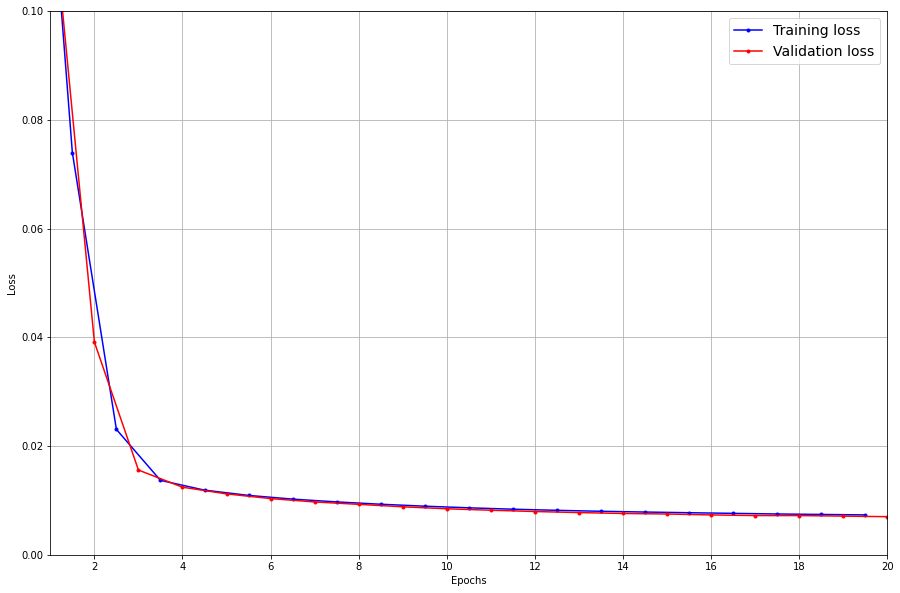

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plt.figure(figsize=(15,10))
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

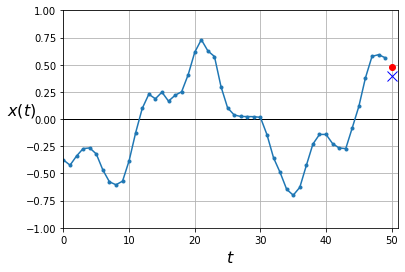

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [ ]:
y_pred.shape, y_valid.shape

((2000, 2), (2000, 1))

In [ ]:
y_pred

array([[ 0.47868747,  0.5129261 ],
       [-0.58268845, -0.60443974],
       [ 0.66849643,  0.6359782 ],
       ...,
       [-0.28462896, -0.26400357],
       [-0.24036819, -0.2445268 ],
       [ 0.5236235 ,  0.48264164]], dtype=float32)

In [ ]:
y_valid

array([[ 0.4000832 ],
       [-0.50259125],
       [ 0.69304645],
       ...,
       [-0.25712416],
       [-0.2791788 ],
       [ 0.6290542 ]], dtype=float32)

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 0.0000e+00


[0.010884956456720829, 0.0]

선형모델은 각 입력 뉴런에 대해 (타임스텝)마다 하나의 파라미터를 가지고 편향이있다.(총 51개의 파라미터가있다)

반면 기본 RNN의 순환뉴런은 입력과 은닉 상태차원 마다 하나의 파라미터를 가지고 편향이있다.  
기본 RNN에는 총 3개의 파라미터가 있다

### 심층 RNN

RNN셀을 여러층으로 쌓는 것

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 25ms/step - loss: 0.0591 - val_loss: 0.0042
Epoch 2/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 3/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 4/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 7/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 8/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 10/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0028 - val_lo

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.weights

[<tf.Variable 'simple_rnn_1/simple_rnn_cell_1/kernel:0' shape=(1, 20) dtype=float32, numpy=
 array([[ 0.25653824,  0.01989137, -0.3651554 ,  0.30176768,  0.0752741 ,
          0.48334143,  0.18193448, -0.50196004,  0.17500472,  0.30373198,
          0.25094688,  0.08626145,  0.23005965,  0.06615601, -0.09542719,
         -0.16553685,  0.43529248,  0.04887949,  0.33090577, -0.3137034 ]],
       dtype=float32)>,
 <tf.Variable 'simple_rnn_1/simple_rnn_cell_1/recurrent_kernel:0' shape=(20, 20) dtype=float32, numpy=
 array([[-0.01524329, -0.2723905 , -0.3045539 ,  0.33658445,  0.01160054,
         -0.45261183, -0.1827098 ,  0.18904224,  0.08754157,  0.01377211,
         -0.08560791, -0.3861814 , -0.20837294,  0.22494392, -0.04884638,
          0.0722484 ,  0.14388314, -0.16576427, -0.05640207,  0.01217586],
        [ 0.05427882, -0.09507022,  0.11896149, -0.31477815,  0.01433821,
         -0.08901422,  0.1699594 ,  0.06226345,  0.21715932,  0.25457314,
         -0.20814358, -0.11198992,  0.

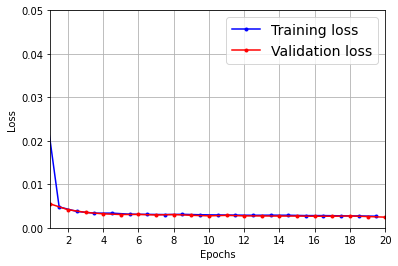

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0025


0.002450787927955389

다른 활성화  함수를 사용하려면 출력층을 Dense층으로 바꾼다.  
더 빠르면서 정확도는 비슷하다.  
원하는 활성화 함수도 사용 가능하다.  

이렇게 바꾸려면 마지막이 된 두번째 순환 층에서 return_sequences=True를 제거해야한다.

return_sequences 설명
https://m.blog.naver.com/PostView.nhn?blogId=chunjein&logNo=221589624838&proxyReferer=https:%2F%2Fwww.google.com%2F


In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 5s 16ms/step - loss: 0.0126 - val_loss: 0.0037
Epoch 2/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 4/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 7/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 8/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0028 - val_lo

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 20)                820       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0025


0.0025114286690950394

### 여러 타임스텝 앞을 예측하기
1스텝이 아니라 10스텝 앞의 값으로 타깃을 바꾸머 10스텝 앞을 예측하는 방법이다.  


RNN을 훈련하여 다음 값 10개를 한번에 예측  
시퀀스-투-벡터 모델을 사용하지만 1개가 아니라 10개를 출력한다.   

In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
print(series.shape)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]
print(X_train.shape, Y_train.shape)

(10000, 60, 1)
(7000, 50, 1) (7000, 10)


In [ ]:
# RNN과 10개의 출력층으로 학습
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 18ms/step - loss: 0.1128 - val_loss: 0.0270
Epoch 2/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0240 - val_loss: 0.0176
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0173 - val_loss: 0.0151
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0145 - val_loss: 0.0139
Epoch 5/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0139 - val_loss: 0.0126
Epoch 6/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0132 - val_loss: 0.0125
Epoch 7/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0123 - val_loss: 0.0113
Epoch 8/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0113 - val_loss: 0.0106
Epoch 9/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0107 - val_loss: 0.0120
Epoch 10/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0108 - val_lo

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense (Dense)                (None, 10)                210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [ ]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

In [ ]:
y = model.predict(X_new)
y[...,np.newaxis]

array([[[0.42001978],
        [0.3471145 ],
        [0.2928675 ],
        [0.27238137],
        [0.24055547],
        [0.27829725],
        [0.30267546],
        [0.23284033],
        [0.16495399],
        [0.14005177]]], dtype=float32)

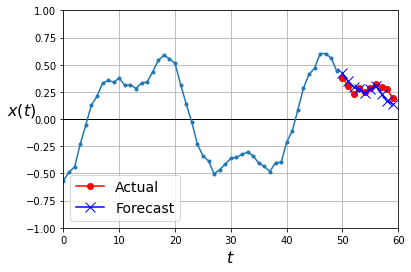

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [ ]:
X_new.shape,Y_pred.shape, Y_new.shape

((1, 50, 1), (1, 10, 1), (1, 10, 1))

In [ ]:
model.evaluate(X_new,Y_pred)

1/1 [==============================] - 0s 222ms/step - loss: 0.0000e+00


0.0

더 개선할 여지가 있다  

시퀀스-투-벡터를 시퀀스-투-시퀀스로 바꾸는 것이다  
더 많은 오차 그레이디언트가 모델에 흐르고 훈련을 안정적으로 만든다  


In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10) # 10000,60,1
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [ ]:
Y_train[0].shape

(50, 10)

시퀀스-투-시퀀스 모델로 바꾸려면 모든 순환층에 retur_sequences=True를 지정해야한다.  
그 다음 모든 타임 스텝에서 출력을 Dense층에 적용해야한다.  


TimeDestributed설명  https://m.blog.naver.com/PostView.nhn?blogId=chunjein&logNo=221589624838&proxyReferer=https:%2F%2Fwww.google.com%2F

In [ ]:

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# 예측과 평가용으로 마지막 타임스텝의 출력만 사용해 평가
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 17ms/step - loss: 0.0682 - last_time_step_mse: 0.0576 - val_loss: 0.0371 - val_last_time_step_mse: 0.0213
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0375 - last_time_step_mse: 0.0241 - val_loss: 0.0320 - val_last_time_step_mse: 0.0185
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0322 - last_time_step_mse: 0.0194 - val_loss: 0.0307 - val_last_time_step_mse: 0.0168
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0298 - last_time_step_mse: 0.0166 - val_loss: 0.0289 - val_last_time_step_mse: 0.0156
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0266 - last_time_step_mse: 0.0125 - val_loss: 0.0267 - val_last_time_step_mse: 0.0129
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0235 - last_time_step_mse: 0.0103 - val_loss: 0.0268 - val_last_time_step_mse: 0.0139
Epoch 7/20
219/219 [==

In [ ]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

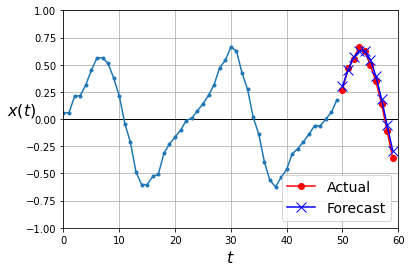

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# 긴 시퀀스 다루기

깊은 RNN은 그레이디언트 소실과 폭주 문제를 갖는다.  
입력의 첫 부분을 조금씩 잊어버린다.

## 불안정한 그레이디언트 문제


RNN에 잘 맞는 정규화는 층 정규화이다.  
배치정규화와 비슷하지만 배치차원에서 정규화 하는대신 특성차원에 대해 정규화한다.  

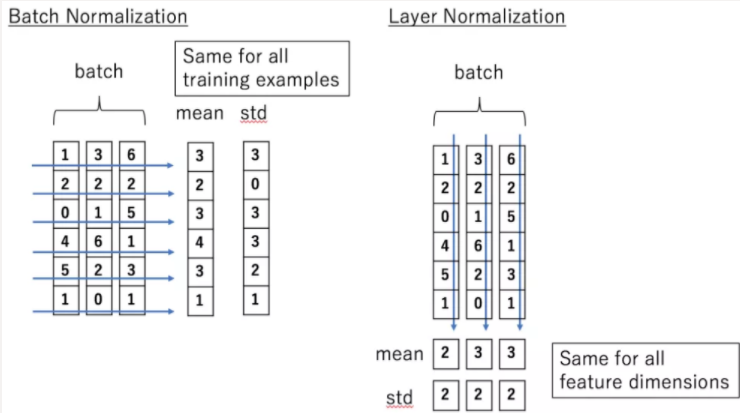

In [ ]:
from tensorflow.keras.layers import LayerNormalization

In [ ]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs): # 유닛개수를 받는다.
        super().__init__(**kwargs)
        self.state_size = units # 은닉 states와 출력 수 같다.
        self.output_size = units
        # 활성화 함수를 수행하기 전에 층정규화를 수행하기 위해 활성화함수 정의하지않고 RNN만듬
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization() # 층정규화
        self.activation = keras.activations.get(activation) # 활성화 함수
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states): # 현재 타임스텝의 인풋과 이전 타임스텝의 은닉 states
        outputs, new_states = self.simple_rnn_cell(inputs, states) # RNN을 거쳐 새 출력과, states 받는다.
        norm_outputs = self.activation(self.layer_norm(outputs)) # 층 정규화를 한 후 활성화함수 취함
        return norm_outputs, [norm_outputs]

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# 예측과 평가용으로 마지막 타임스텝의 출력만 사용해 평가
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 12s 42ms/step - loss: 0.2828 - last_time_step_mse: 0.2865 - val_loss: 0.0714 - val_last_time_step_mse: 0.0572
Epoch 2/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0665 - last_time_step_mse: 0.0531 - val_loss: 0.0562 - val_last_time_step_mse: 0.0426
Epoch 3/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0557 - last_time_step_mse: 0.0421 - val_loss: 0.0498 - val_last_time_step_mse: 0.0354
Epoch 4/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0495 - last_time_step_mse: 0.0342 - val_loss: 0.0449 - val_last_time_step_mse: 0.0298
Epoch 5/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0451 - last_time_step_mse: 0.0308 - val_loss: 0.0418 - val_last_time_step_mse: 0.0270
Epoch 6/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0415 - last_time_step_mse: 0.0267 - val_loss: 0.0385 - val_last_time_step_mse: 0.0233
Epoch 7/20
219/219 [=

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_4 (RNN)                  (None, None, 20)          480       
_________________________________________________________________
rnn_5 (RNN)                  (None, None, 20)          860       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 10)          210       
Total params: 1,550
Trainable params: 1,550
Non-trainable params: 0
_________________________________________________________________


In [ ]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

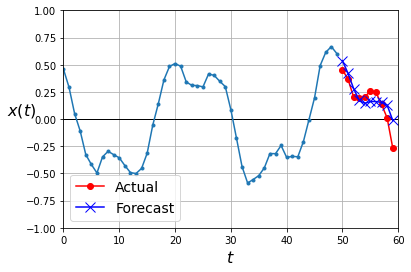

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## 단기기억 문제
어느정도 시간이 지나면 RNN의 상태는 사실상 첫 번재 입력의 흔적을 가지고 있지 않다.  
장기 메모리를 가진 여러 종류의 셀이 연구됐었다.  


### LSTM셀
LSTM(Long sohrt term memory)  
훈련이 빠르게 수렴하고 데이터에 있는 장기간의 의존성을 감지할 것이다.  


아이디어는 네트워크가 장기 상태에 저장할 것, 버릴것, 읽어들일 것을 학습하는 것이다.  


LSTM셀은 중요한 입력을 인식하고(입력게이트역할), 장기 상태에 저장하고, 필요한 기간 동안 이를 보존하고(삭제게이트의 역할), 필요할 대마다 이를 추출하기 위해 학습한다.  
LSTM셀은 시계열, 긴 텍스트, 오디오녹음 등에서 장기 패턴을 잡아내는데 놀라운 성과를 낸다  


In [ ]:
# 예측과 평가용으로 마지막 타임스텝의 출력만 사용해 평가
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 11s 37ms/step - loss: 0.0989 - last_time_step_mse: 0.0895 - val_loss: 0.0528 - val_last_time_step_mse: 0.0325
Epoch 2/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0496 - last_time_step_mse: 0.0295 - val_loss: 0.0396 - val_last_time_step_mse: 0.0181
Epoch 3/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0383 - last_time_step_mse: 0.0171 - val_loss: 0.0351 - val_last_time_step_mse: 0.0165
Epoch 4/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0338 - last_time_step_mse: 0.0150 - val_loss: 0.0314 - val_last_time_step_mse: 0.0135
Epoch 5/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0313 - last_time_step_mse: 0.0132 - val_loss: 0.0297 - val_last_time_step_mse: 0.0120
Epoch 6/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0297 - last_time_step_mse: 0.0122 - val_loss: 0.0288 - val_last_time_step_mse: 0.0123
Epoch 7/20
219/219 [=

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 10)          210       
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0232 - last_time_step_mse: 0.0087


[0.02324882335960865, 0.00868389755487442]

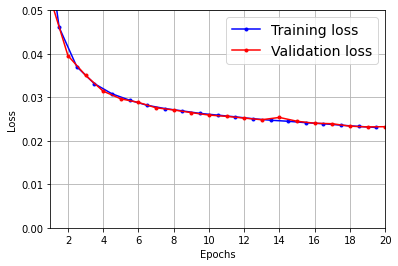

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

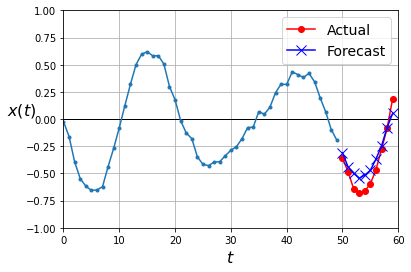

In [ ]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### GRU 셀
게이트순환유닛(gated recurrent unit)

LSTM의 간소화된 버전이고 유사하게 작동한다.

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 12s 39ms/step - loss: 0.0997 - last_time_step_mse: 0.0958 - val_loss: 0.0523 - val_last_time_step_mse: 0.0414
Epoch 2/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0499 - last_time_step_mse: 0.0398 - val_loss: 0.0429 - val_last_time_step_mse: 0.0318
Epoch 3/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0425 - last_time_step_mse: 0.0317 - val_loss: 0.0391 - val_last_time_step_mse: 0.0276
Epoch 4/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0392 - last_time_step_mse: 0.0272 - val_loss: 0.0352 - val_last_time_step_mse: 0.0214
Epoch 5/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0348 - last_time_step_mse: 0.0207 - val_loss: 0.0321 - val_last_time_step_mse: 0.0172
Epoch 6/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0319 - last_time_step_mse: 0.0169 - val_loss: 0.0297 - val_last_time_step_mse: 0.0146
Epoch 7/20
219/219 [=

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 20)          1380      
_________________________________________________________________
gru_1 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 10)          210       
Total params: 4,110
Trainable params: 4,110
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.evaluate(X_valid,Y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0231 - last_time_step_mse: 0.0101


[0.02314426377415657, 0.010082338005304337]

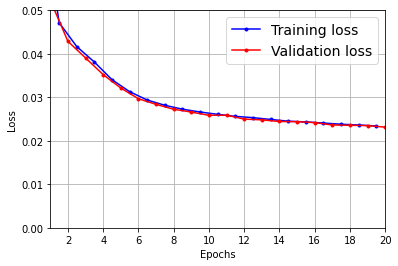

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

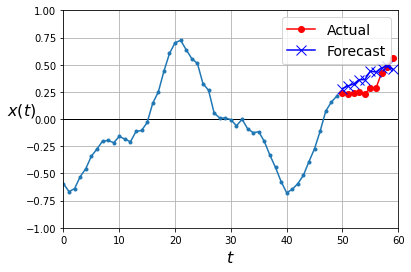

In [ ]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### 1D 합성곱층을 사용해 시퀀스 처리하기
1D합성곱 층이 몇개의 커널을 시퀀스 위를 슬라이딩하여 커널마다 1D 특성맵을 출력한다.  
각 커널은 매우 짧은 하나의 순차 패턴을 감지하도록 학습된다.

모델이 중요하지 않은 세부 사항은 버리고 유용한 정보를 보전하도록 학습할 수 있다.   

합성곱층으로 시퀀스 길이를 줄이면 GRU층이 더 긴 패턴을 감지하는데 도움이 된다.


1D conv layer with kernel size 4, stride 2, VALID padding:  
```
              |-----2-----|     |-----5---...------|     |-----23----|  
        |-----1-----|     |-----4-----|   ...      |-----22----|  
  |-----0----|      |-----3-----|     |---...|-----21----|  
```
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49  
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50  
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59  

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49  
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59   

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 8s 23ms/step - loss: 0.0927 - last_time_step_mse: 0.0870 - val_loss: 0.0462 - val_last_time_step_mse: 0.0375
Epoch 2/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0438 - last_time_step_mse: 0.0369 - val_loss: 0.0363 - val_last_time_step_mse: 0.0303
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0343 - last_time_step_mse: 0.0272 - val_loss: 0.0292 - val_last_time_step_mse: 0.0202
Epoch 4/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0283 - last_time_step_mse: 0.0191 - val_loss: 0.0255 - val_last_time_step_mse: 0.0148
Epoch 5/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0249 - last_time_step_mse: 0.0144 - val_loss: 0.0237 - val_last_time_step_mse: 0.0127
Epoch 6/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0235 - last_time_step_mse: 0.0130 - val_loss: 0.0225 - val_last_time_step_mse: 0.0114
Epoch 7/20
219/219 [==

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 20)          100       
_________________________________________________________________
gru_2 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
gru_3 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 10)          210       
Total params: 5,350
Trainable params: 5,350
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.evaluate(X_valid,Y_valid[:,3::2])

63/63 [==============================] - 0s 4ms/step - loss: 0.0185 - last_time_step_mse: 0.0084


[0.018489530310034752, 0.008405816741287708]

## wavenet  
이 네트워크는 층마다 팽창비율을 두배로 눌리는 1D 합성곱 층을 쌓았다.  

첫번째 합성곱층이 한번에 2개의 타임스텝만 바라본다.  
다음 층은 4개의 타임스텝을 보고  
다음은 8개의 타임스텝을 보는 식이다.  

이런식으로 하위층은 단기 패턴으 학습하고 상위층은 장기패턴을 학습한다.  

In [ ]:

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
# causal 패딩사용 -> 미래의 시퀀스 누수 막는다. 팽창비율 1,2,4,8 층 * 2
# 패딩 덕분에 모든 합성곱층은 입력시퀀스의 길이와 동일한 시퀀스를 출력한다
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))# 출력에 conv층 사용
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 13ms/step - loss: 0.1010 - last_time_step_mse: 0.0938 - val_loss: 0.0379 - val_last_time_step_mse: 0.0234
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0356 - last_time_step_mse: 0.0213 - val_loss: 0.0304 - val_last_time_step_mse: 0.0167
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0301 - last_time_step_mse: 0.0163 - val_loss: 0.0277 - val_last_time_step_mse: 0.0139
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0277 - last_time_step_mse: 0.0141 - val_loss: 0.0268 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0265 - last_time_step_mse: 0.0131 - val_loss: 0.0258 - val_last_time_step_mse: 0.0129
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0254 - last_time_step_mse: 0.0123 - val_loss: 0.0242 - val_last_time_step_mse: 0.0111
Epoch 7/20
219/219 [==